In [ ]:
import pandas as pd
import numpy as np
from numpy.random import seed
from numpy.random import normal

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams


import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler



from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, MaxPooling1D
from keras.models import Model
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit

# from keras.optimizers import RMSprop, adam

## Importing Data

In [2]:
day1_dataset_1min = pd.read_csv('Data Slices/5_days_timeseries_data/1min.csv')
day1_dataset_10min = pd.read_csv('Data Slices/5_days_timeseries_data/10min.csv')
day1_dataset_30min = pd.read_csv('Data Slices/5_days_timeseries_data/30min.csv')
day1_dataset_60min = pd.read_csv('Data Slices/5_days_timeseries_data/60min.csv')

In [3]:
def get_X_and_y(df, x_columns, y_columns):
    X = df[x_columns]
    y = df[y_columns]
    return X, y

In [4]:
def get_daily_sequences(X, y, feature_columns, sequence_dict = {}):
    for collection, group in X.groupby("collection"):
        features = group[group.columns.intersection(feature_columns)]
        blacklist = y[y.collection == collection].iloc[0].blacklisted
        if sequence_dict.get(collection):
            sequence_dict[collection][0].append(features)
        else:
            sequence_dict[collection] = ([features], blacklist)
    return sequence_dict

In [5]:
def get_daily_sequences(X, y, feature_columns, sequence_dict = {}):
    for collection, group in X.groupby("collection"):
        features = group[group.columns.intersection(feature_columns)]
        blacklist = y[y.collection == collection].iloc[0].blacklisted
        if sequence_dict.get(collection):
            sequence_dict[collection][0].append(features)
        else:
            sequence_dict[collection] = ([features], blacklist)
    return sequence_dict

In [6]:
def scale_dataset(sequences, columns = ['Price_USD', 'Price_Crypto', 'volume', 'density', 'vertex_count', 
                              'edge_count','vertext_edge_ratio'], fitted_scaler = None):
    collection_blacklist_dict = {sequence[0]:sequence[2] for sequence in sequences}
    concat_df = pd.concat([sequence[1] for sequence in sequences])
    if fitted_scaler is None:
        fitted_scaler = StandardScaler()
        fitted_scaler.fit(concat_df[columns])
    concat_df[columns] = fitted_scaler.transform(concat_df[columns])
    return  [(collection, group[columns], collection_blacklist_dict[collection]) 
             for collection, group in concat_df.groupby("collection")] , fitted_scaler

In [7]:
def get_all_sequences(all_df):
    sequence_dict = {}
    for df in all_df: 
        df = df.drop(['Unnamed: 0'], axis=1)
        x_columns =  ['Datetime_updated_seconds','Price_USD','Price_Crypto','volume','density',
                   'vertex_count','edge_count','collection']
        y_columns = ['blacklisted','collection']
        feature_columns=['Price_USD','Price_Crypto','volume',
                         'density', 'vertex_count','edge_count', 'collection', 'vertext_edge_ratio']
        X, y= get_X_and_y(df, x_columns, y_columns)
        X['vertext_edge_ratio'] = X['vertex_count']/X['edge_count']
        sequence_dict = get_daily_sequences(X, y, feature_columns, sequence_dict)
    return sequence_dict

In [8]:
def retrieve_all_train_test_sequences(all_df):
    train_test_sequences = []
    all_sequence_dict = list(get_all_sequences(all_df).items())
    
    x = [sequence for sequence in all_sequence_dict]
    y = [sequence[1][1] for sequence in all_sequence_dict]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
         
    for train, test in  sss.split(x, y):
        X_train = [x[idx] for idx in train]
        X_test = [x[idx] for idx in test]
    return X_train, X_test

In [52]:
sample_all_sequence = get_all_sequences([day1_dataset_1min, day1_dataset_10min, day1_dataset_30min, day1_dataset_60min])

<ipython-input-7-ba7f0a36a736>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['vertext_edge_ratio'] = X['vertex_count']/X['edge_count']


In [ ]:
[sequence[1][1] for sequence in list(sample_all_sequence.items())[0:2]]

In [9]:
train_sequences, test_sequences = retrieve_all_train_test_sequences([day1_dataset_1min, day1_dataset_10min,
                                                                     day1_dataset_30min,
                                                                     day1_dataset_60min])

<ipython-input-7-ba7f0a36a736>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['vertext_edge_ratio'] = X['vertex_count']/X['edge_count']


In [10]:
def scale_train_test_sequences(train_sequences, test_sequences):
    scaled_train_dataset_dict = {}
    scaled_test_dataset_dict = {}
    scaled_train_dataset= []
    scaled_test_dataset= []
    length = len(train_sequences[0][1][0])
    for n in range(length):
        train_scaled, scaler = scale_dataset([(sequence[0], sequence[1][0][n], sequence[1][1]) for sequence in
                                              train_sequences])
        test_scaled, _ = scale_dataset([(sequence[0], sequence[1][0][n], sequence[1][1]) for sequence in
                                        test_sequences],
                      fitted_scaler= scaler)
        scaled_train_dataset.append(train_scaled)
        scaled_test_dataset.append(test_scaled)

    for scale_sequence in scaled_train_dataset:
        for collection in scale_sequence:
            if scaled_train_dataset_dict.get(collection[0]):
                scaled_train_dataset_dict[collection[0]][0].append(collection[1])
            else:
                scaled_train_dataset_dict[collection[0]] = ([collection[1]], collection[2])

    for scale_sequence in scaled_test_dataset:
        for collection in scale_sequence:
            if scaled_test_dataset_dict.get(collection[0]):
                scaled_test_dataset_dict[collection[0]][0].append(collection[1])
            else:
                scaled_test_dataset_dict[collection[0]] = ([collection[1]], collection[2])
                
    return list(scaled_train_dataset_dict.values()), list(scaled_test_dataset_dict.values())

In [11]:
train_values, test_values = scale_train_test_sequences(train_sequences,test_sequences)

In [12]:
test_values[7][0][0]

,Price_USD,Price_Crypto,volume,density,vertex_count,edge_count,vertext_edge_ratio
144000,-0.210093,-0.231693,6.716017,1.384928,-0.298881,-0.229725,1.267608
144001,-0.210093,-0.231693,-0.046785,1.384928,-0.298881,-0.229725,1.267608
144002,-0.210093,-0.231693,-0.046785,1.384928,-0.298881,-0.229725,1.267608
144003,-0.210093,-0.231693,-0.046785,1.384928,-0.298881,-0.229725,1.267608
144004,-0.210093,-0.231693,-0.046785,1.384928,-0.298881,-0.229725,1.267608
...,...,...,...,...,...,...,...
151195,-0.213662,-0.234063,-0.046785,1.384928,-0.298881,-0.229725,1.267608
151196,-0.213662,-0.234063,-0.046785,1.384928,-0.298881,-0.229725,1.267608
151197,-0.213662,-0.234063,-0.046785,1.384928,-0.298881,-0.229725,1.267608
151198,-0.213662,-0.234063,-0.046785,1.384928,-0.298881,-0.229725,1.267608


In [13]:
train_values[356][0][0]

,Price_USD,Price_Crypto,volume,density,vertex_count,edge_count,vertext_edge_ratio
3254400,-0.215687,-0.191410,13.478818,0.466310,-0.274622,-0.212204,-0.036901
3254401,-0.211617,-0.191410,20.241620,-0.268584,-0.226104,-0.177164,-0.689156
3254402,-0.209892,-0.191410,13.478818,-0.452308,-0.201846,-0.159644,-0.819607
3254403,-0.201095,-0.167714,20.241620,-0.583539,-0.177587,-0.142123,-0.906574
3254404,-0.201198,-0.171663,20.241620,-0.583539,-0.177587,-0.142123,-0.906574
...,...,...,...,...,...,...,...
3261595,-0.201577,-0.191410,-0.046785,-1.046708,0.065001,0.033079,-1.178347
3261596,-0.201577,-0.191410,-0.046785,-1.046708,0.065001,0.033079,-1.178347
3261597,-0.201577,-0.191410,-0.046785,-1.046708,0.065001,0.033079,-1.178347
3261598,-0.201577,-0.191410,-0.046785,-1.046708,0.065001,0.033079,-1.178347


## Model

In [15]:
model_shapes = [train_values[0][0][n].shape for n in range(len(train_values[0][0]))]

In [16]:
model_shapes

[(7200, 7), (720, 7), (240, 7), (120, 7)]

In [33]:
filters = [200,200,200,200]
k_sizes = [500,50,30,20]

In [34]:
def get_base_model(shape, k_size = k_sizes[0], num_filters = filters[0]):
    print("base model shape", shape)
    input_seq = Input(shape=shape)
    nb_filters = num_filters
    convolved = Conv1D(num_filters, k_size, padding="same", activation="relu")(input_seq)
    processed = GlobalMaxPooling1D()(convolved)
    #todo: fix maxpooling
#     processed = MaxPooling1D(pool_size=2, strides=1, padding='same')(convolved)
    compressed = Dense(100, activation="relu")(processed)
    compressed = Dropout(0.3)(compressed)
    model = Model(inputs=input_seq, outputs=compressed)
    model.summary()
    return model

In [35]:
def main_model(shapes, filters, k_sizes):
    inputs = [Input(shape=shape, name=f'input{n}')for n, shape in enumerate(shapes)]
    sub_models = [ get_base_model(shape, k_size = k_sizes[n], num_filters=filters[n]) 
                  for n, shape in enumerate(shapes)]
    print(sub_models[0].output)
    embeddings = [ model(inputs[n]) for n, model in enumerate(sub_models)]
    merged = Concatenate()(embeddings)
    #todo: tweak dense be modifiable 
    layer1 = Dense(100, activation='relu', name ='hidden_layer1')(merged)
    layer2 = Dense(50, activation='relu', name ='hidden_layer2')(layer1)
    layer3 = Dense(25, activation='relu', name ='hidden_layer3')(layer2)
    out = Dense(1, activation='sigmoid')(layer3)
    model = Model(inputs=inputs, outputs=out)
    return model

In [36]:
def run_model(train, validation, model_shapes, filters, k_sizes):
    es = keras.callbacks.EarlyStopping(min_delta=0.00001, patience=20)
    model = main_model(model_shapes, filters, k_sizes)
    model.compile(loss='binary_crossentropy', # categorical_crossentropy
                          optimizer='adam', #sgd, nadam, adam, rmsprop
                          metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                                   tf.keras.metrics.AUC(curve='PR')])
    model.summary()
    model_hist = model.fit(train,
                               validation_data=validation,
                               batch_size=200, epochs=2000, 
                           callbacks=[es]
                          )
    return model_hist, model

In [37]:
def get_formatted_inputs(values):
    x_train_arr = []
    length = len(values)
    for n in range(len(values[0][0])):
        x_train = [sequence[0][n] for sequence in values]
        shape = x_train[0].shape
        x_train =  np.stack(x_train)
        x_train = x_train.reshape(length, shape[0], shape[1])
        x_train_arr.append(x_train)
    return x_train_arr, [sequence[1] for sequence in values]

In [38]:
def retrieve_tensor_datasets(train, test):
    formatted_train = ({f'input{n}': data for n, data in enumerate(train[0]) }, train[1])
    formatted_test = ({f'input{n}': data for n, data in enumerate(test[0]) }, test[1])
    train_dataset = tf.data.Dataset.from_tensor_slices(formatted_train).batch(200)
    test_dataset = tf.data.Dataset.from_tensor_slices(formatted_test).batch(200)
    return train_dataset, test_dataset

In [39]:
dataset, validation = retrieve_tensor_datasets(get_formatted_inputs(train_values),
                                               get_formatted_inputs(test_values) )

In [40]:
model_hist, model = run_model(dataset, validation, model_shapes, filters, k_sizes)

base model shape (7200, 7)
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 7200, 7)]         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 7200, 200)         700200    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
Total params: 720,300
Trainable params: 720,300
Non-trainable params: 0
_________________________________________________________________
base model shape (720, 7)
Model: "model_11"
_______________________________________________

Epoch 3/2000
4/4 [==============================] - 109s 28s/step - loss: 0.5501 - binary_accuracy: 0.7208 - precision_2: 0.5000 - recall_2: 0.0136 - auc_2: 0.4252 - val_loss: 0.5484 - val_binary_accuracy: 0.7259 - val_precision_2: 1.0000 - val_recall_2: 0.0182 - val_auc_2: 0.4570
Epoch 4/2000
4/4 [==============================] - 109s 28s/step - loss: 0.5549 - binary_accuracy: 0.7170 - precision_2: 0.3636 - recall_2: 0.0182 - auc_2: 0.4111 - val_loss: 0.5517 - val_binary_accuracy: 0.7208 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_2: 0.4145
Epoch 5/2000
4/4 [==============================] - 109s 28s/step - loss: 0.5442 - binary_accuracy: 0.7208 - precision_2: 0.5000 - recall_2: 0.0136 - auc_2: 0.4535 - val_loss: 0.5558 - val_binary_accuracy: 0.7259 - val_precision_2: 1.0000 - val_recall_2: 0.0182 - val_auc_2: 0.4410
Epoch 6/2000
4/4 [==============================] - 108s 28s/step - loss: 0.5412 - binary_accuracy: 0.7259 - precision_2: 0.6667 - recall_2: 0.036

KeyboardInterrupt: 

In [ ]:
prediction[prediction <=0.5] = 0
prediction[prediction >0.5] = 1

In [ ]:
[pred[0] for pred in prediction.tolist()]

In [74]:
def plot_training_curves(history, title=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_binary_accuracy'] + history.history['binary_accuracy']),
                        max(history.history['val_binary_accuracy'] + history.history['binary_accuracy']))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['binary_accuracy']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['binary_accuracy'], label = 'accuracy')
    ax[1].plot(index, history.history['val_binary_accuracy'], label = 'val_accuracy')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

In [82]:
def plot_training_curves_auc(history, title=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_auc'] + history.history['auc']),
                        max(history.history['val_auc'] + history.history['auc']))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['auc']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['auc'], label = 'auc')
    ax[1].plot(index, history.history['val_auc'], label = 'val_auc')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('AUC')
    ax[1].set_ylabel('auc')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

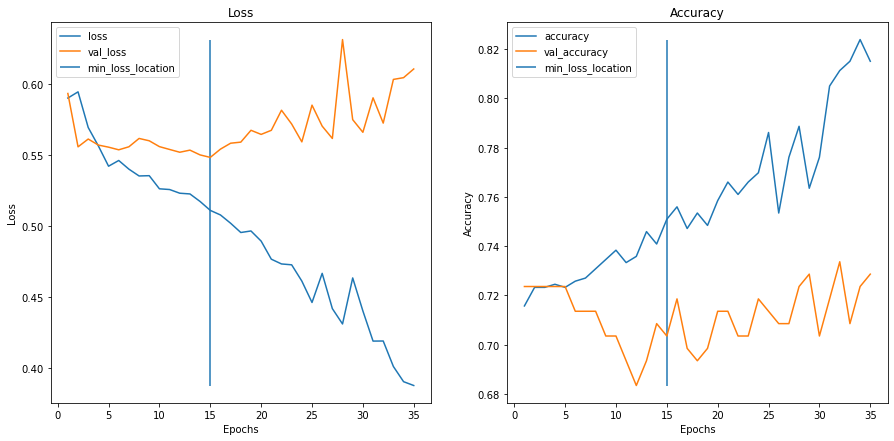

In [76]:
plot_training_curves(history=model_hist)

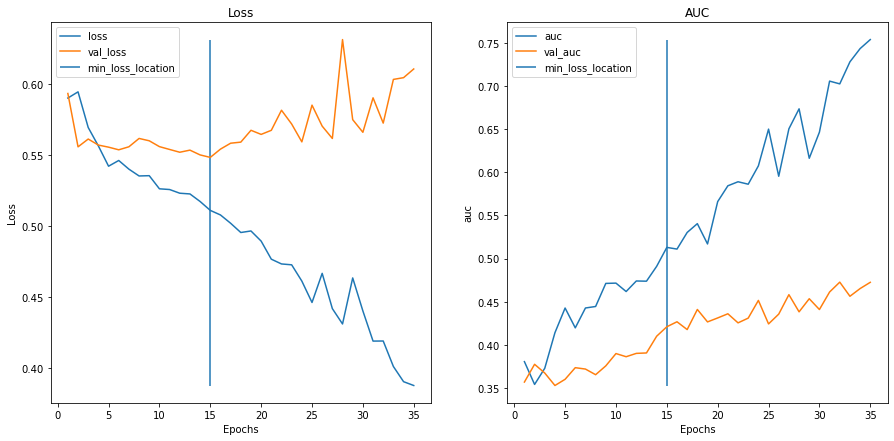

In [83]:
plot_training_curves_auc(history=model_hist)

array([-0.12373786, -0.3946075 ,  1.8864716 , ..., -1.04683539,
       -0.31209261,  0.86439332])

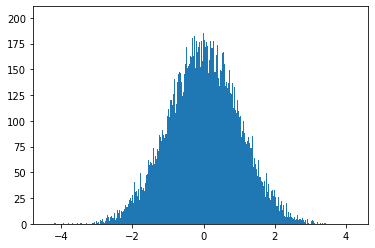

In [40]:
import matplotlib.pyplot as plt

plt.show()

In [41]:
arr = np.array(count)

In [42]:
bins

array([-4.36245984, -4.35651201, -4.35056418, ...,  4.19051944,
        4.19646727,  4.2024151 ])

In [43]:
arr

array([1., 0., 0., ..., 0., 0., 1.])

In [44]:
def fill_zeros_with_last(arr):
    prev = np.arange(len(arr))
    prev[arr == 0] = 0
    prev = np.maximum.accumulate(prev)
    return arr[prev]

In [87]:
def generate_blacklisted(times):
    all_blacklisted = []
    for _ in range(times):
        data = normal(loc=0, scale=1, size=1440*30)
        count, bins, ignored = plt.hist(data, 1440)
        all_blacklisted.append(fill_zeros_with_last(count))
    return all_blacklisted

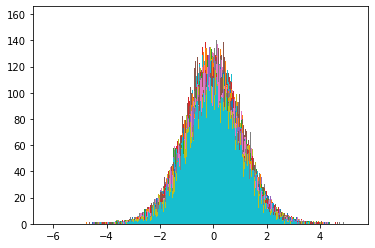

In [96]:
sample_blaclisted = generate_blacklisted(200)

array([   0,    1,    2, ..., 1437, 1438, 1439])

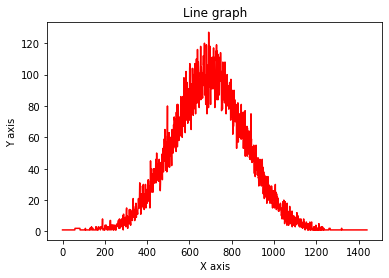

In [97]:
plt.title("Line graph")
plt.xlabel("X axis")
plt.ylabel("Y axis")b
plt.plot(np.array([n for n in range(1440)]), sample_blaclisted[150], color ="red")
plt.show()

In [101]:
import os
import glob

In [104]:
path =  os.getcwd()+'/Data Slices/5_days_all_metrics'
csv_files = glob.glob(os.path.join(path, "*.csv"))
my_dict = {}
  
# loop over the list of csv files
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f)
    
    
    # print the location and filename
    print('Location:', f)
    print('File Name:', f.split("/")[-1])
    
    my_dict[f.split("/")[-1]] = df
    # print the content
    print('Content:')
#     display(df)
    print()

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/space1catzzz.csv
File Name: space1catzzz.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/seven1111111.csv
File Name: seven1111111.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/alienwmorlds.csv
File Name: alienwmorlds.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/trocproclock.csv
File Name: trocproclock.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/alienswordls.csv
File Name: alienswordls.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/aliennwiorld.csv
File Name: aliennwiorld.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/drzammsydolo.csv
File Name: drzammsydolo.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/simagigit453.csv
File Name: simagigit453.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/proartgalley.csv
File Name: proartgalley.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/mddeesignerr.csv
File Name: mddeesignerr.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/ikimonoworld.csv
File Name: ikimonoworld.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/driiiipstars.csv
File Name: driiiipstars.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/alienftshelk.csv
File Name: alienftshelk.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/flegandsnfts.csv
File Name: flegandsnfts.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/gybniftyclub.csv
File Name: gybniftyclub.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/wizardcrdgme.csv
File Name: wizardcrdgme.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/missteennfts.csv
File Name: missteennfts.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/lurk24dotcom.csv
File Name: lurk24dotcom.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/cyberbullyin.csv
File Name: cyberbullyin.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/cc32dninenft.csv
File Name: cc32dninenft.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/upland.cards.csv
File Name: upland.cards.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/cryptonormyz.csv
File Name: cryptonormyz.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/orbitofsolus.csv
File Name: orbitofsolus.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/cryptenthuss.csv
File Name: cryptenthuss.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/lastdaysfiat.csv
File Name: lastdaysfiat.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/upliftart.csv
File Name: upliftart.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/comicsdcntrl.csv
File Name: comicsdcntrl.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/itsartinarts.csv
File Name: itsartinarts.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/aiienvvorlds.csv
File Name: aiienvvorlds.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/allenvvorlds.csv
File Name: allenvvorlds.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/jrgtradecard.csv
File Name: jrgtradecard.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/cybernosfrt1.csv
File Name: cybernosfrt1.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/brucewaxnftz.csv
File Name: brucewaxnftz.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/ttvnewmatic1.csv
File Name: ttvnewmatic1.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/mlbttoppsver.csv
File Name: mlbttoppsver.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/makosgallery.csv
File Name: makosgallery.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/unlimitedwax.csv
File Name: unlimitedwax.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/meanderdot11.csv
File Name: meanderdot11.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/bakuretsuhun.csv
File Name: bakuretsuhun.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/officialhero.csv
File Name: officialhero.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/rabbithole11.csv
File Name: rabbithole11.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/heavymetal4u.csv
File Name: heavymetal4u.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/mlbxtoppsver.csv
File Name: mlbxtoppsver.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/koralovelace.csv
File Name: koralovelace.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/legendsofnft.csv
File Name: legendsofnft.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/tidbytsnfts1.csv
File Name: tidbytsnfts1.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/graboidartcc.csv
File Name: graboidartcc.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/girlpinupart.csv
File Name: girlpinupart.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/exit1imbowax.csv
File Name: exit1imbowax.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/howtotieatie.csv
File Name: howtotieatie.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/iramadhanart.csv
File Name: iramadhanart.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/codingisland.csv
File Name: codingisland.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/toltecwarrio.csv
File Name: toltecwarrio.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/alllenworlds.csv
File Name: alllenworlds.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/eosdetfanart.csv
File Name: eosdetfanart.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/ultrahorrorr.csv
File Name: ultrahorrorr.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/uplandcardss.csv
File Name: uplandcardss.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/dingleberrie.csv
File Name: dingleberrie.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/mrtreefanart.csv
File Name: mrtreefanart.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/dokidokipunk.csv
File Name: dokidokipunk.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/alienwoorlds.csv
File Name: alienwoorlds.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/blockblumpas.csv
File Name: blockblumpas.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/architectart.csv
File Name: architectart.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/army.csv
File Name: army.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/luckycharm21.csv
File Name: luckycharm21.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/everydaynfts.csv
File Name: everydaynfts.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slice

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/buildingsarc.csv
File Name: buildingsarc.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/aliiennworld.csv
File Name: aliiennworld.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/worldtravelx.csv
File Name: worldtravelx.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/wampastompa1.csv
File Name: wampastompa1.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/famlyphoto55.csv
File Name: famlyphoto55.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/coitalgroups.csv
File Name: coitalgroups.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/porkbuscards.csv
File Name: porkbuscards.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/zeugencorona.csv
File Name: zeugencorona.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/1amazingbook.csv
File Name: 1amazingbook.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/theweewizard.csv
File Name: theweewizard.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/proantarktis.csv
File Name: proantarktis.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/underpunks55.csv
File Name: underpunks55.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/niftysticker.csv
File Name: niftysticker.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/dogemoncards.csv
File Name: dogemoncards.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/smartowl1123.csv
File Name: smartowl1123.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/risingstarga.csv
File Name: risingstarga.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/artcryptogif.csv
File Name: artcryptogif.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/coindodocard.csv
File Name: coindodocard.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/mutants.r2.csv
File Name: mutants.r2.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/cryptobadzzz.csv
File Name: cryptobadzzz.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/joinmyshower.csv
File Name: joinmyshower.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/aalienworlds.csv
File Name: aalienworlds.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/nastyhooks4u.csv
File Name: nastyhooks4u.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_2022/Data Slices/5_days_all_metrics/cheesmansart.csv
File Name: cheesmansart.csv
Content:

Location: /Users/jorgeolmos/Documents/capstone/SMU_MSDS_CAPSTONE_202

In [105]:
list(my_dict.values())[0]

,Unnamed: 0,index,Smart_contract,ID_token,Transaction_hash,Seller_address,Seller_username,Buyer_address,Buyer_username,Image_url_1,...,Permanent_link,Unique_id_collection,Collection_cleaned,Category,density,vertex_count,edge_count,max_diameter,max_radius,max_periphery
0,0,3039376,atomicassets,1.099522e+12,NaN,jxpb4.wam,NaN,o5gqy.wam,NaN,QmSsiEynYQaD9pLCH9R3y3WYdxnVtdGiiCE2hjMEFW1iDK,...,NaN,"('space1catzzz', '1099521591310')",Space,Other,1.000000,2,1,1,1,2
1,1,3039349,atomicassets,1.099522e+12,NaN,jxpb4.wam,NaN,iykb2.wam,NaN,QmSsiEynYQaD9pLCH9R3y3WYdxnVtdGiiCE2hjMEFW1iDK,...,NaN,"('space1catzzz', '1099521591311')",Space,Other,0.666667,3,2,2,1,2
2,2,3000630,atomicassets,1.099522e+12,NaN,jxpb4.wam,NaN,uvmb4.wam,NaN,QmcVNJpeXeaAa2tRvxFqP9z23LNp5xjKiE3EPE3Dz9ncC1,...,NaN,"('space1catzzz', '1099521811858')",Space,Other,0.500000,4,3,2,1,3
